# load the image

In [ ]:

import os
from tkinter import Tk, filedialog

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


def choose_image_with_dialog():
    """
    打开系统文件选择对话框，选择一张图片并返回：
    - img_array: np.ndarray, RGB 格式的图像数据
    - img_path:  str, 图像文件完整路径
    如果用户取消选择，返回 (None, None)
    """
    # 创建一个隐藏的 Tk 根窗口，只用于弹出对话框
    root = Tk()
    root.withdraw()  # 隐藏主窗口

    filetypes = [
        ("Image files", "*.bmp *.png *.jpg *.jpeg *.tif *.tiff"),
        ("BMP", "*.bmp"),
        ("JPEG", "*.jpg *.jpeg"),
        ("PNG", "*.png"),
        ("TIFF", "*.tif *.tiff"),
        ("All files", "*.*"),
    ]

    img_path = filedialog.askopenfilename(
        title="请选择要分析的图像",
        filetypes=filetypes,
    )

    # 用户点了“取消”
    if not img_path:
        print("未选择任何文件。")
        return None, None

    # 打开图片并转换为 RGB（避免灰度/带 alpha 通道不统一）
    img = Image.open(img_path).convert("RGB")
    img_array = np.array(img)

    print(f"已选择文件：{img_path}")
    print(f"图像尺寸：{img_array.shape[1]} x {img_array.shape[0]} (宽 x 高)")

    return img_array, img_path


def show_image(img_array, title="Selected image"):
    """
    使用 matplotlib 显示图像
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(img_array)
    plt.axis("off")
    plt.title(title)
    plt.show()


# 实际调用示例：
img, path = choose_image_with_dialog()
if img is not None:
    show_image(img, title=os.path.basename(path))


# hist

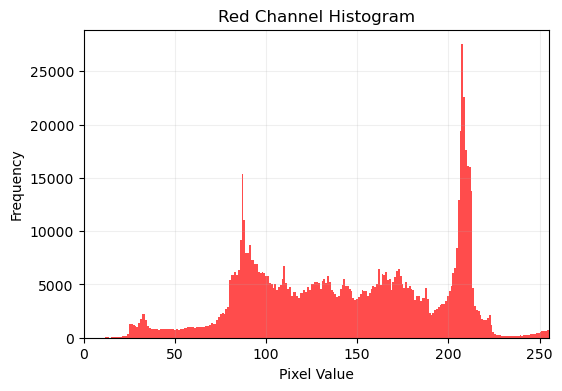

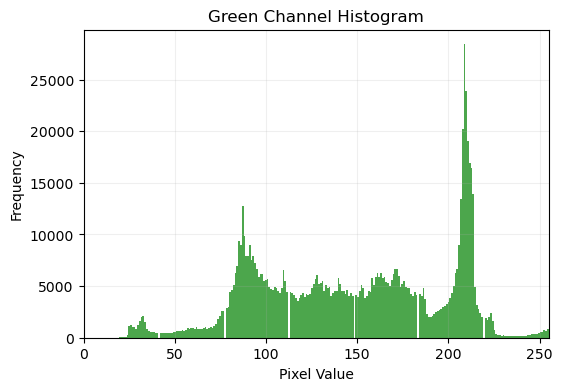

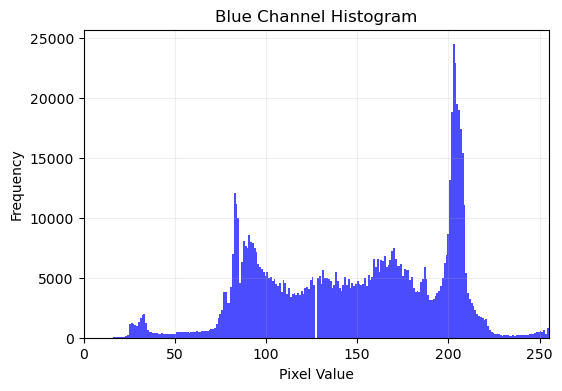

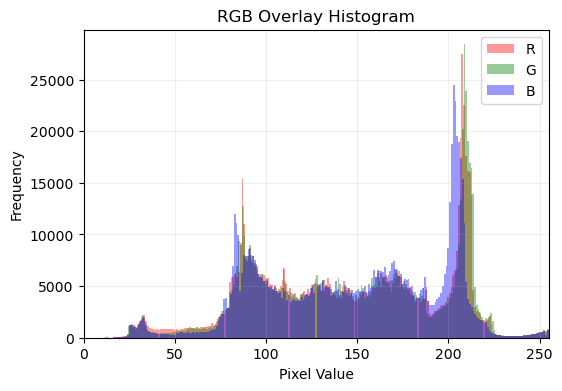

In [5]:


def plot_rgb_histograms(img):
    """
    绘制 R、G、B 三个通道的直方图，
    以及一个 RGB 叠加（半透明）直方图。
    """

    # 将图像拆成 R, G, B
    R = img[:, :, 0].flatten()
    G = img[:, :, 1].flatten()
    B = img[:, :, 2].flatten()

    bins = 256  # 0-255

    # ------------------------
    # 1) R 通道直方图
    # ------------------------
    plt.figure(figsize=(6,4))
    plt.hist(R, bins=bins, color='red', alpha=0.7)
    plt.title("Red Channel Histogram")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.xlim(0,255)
    plt.grid(alpha=0.2)
    plt.show()

    # ------------------------
    # 2) G 通道直方图
    # ------------------------
    plt.figure(figsize=(6,4))
    plt.hist(G, bins=bins, color='green', alpha=0.7)
    plt.title("Green Channel Histogram")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.xlim(0,255)
    plt.grid(alpha=0.2)
    plt.show()

    # ------------------------
    # 3) B 通道直方图
    # ------------------------
    plt.figure(figsize=(6,4))
    plt.hist(B, bins=bins, color='blue', alpha=0.7)
    plt.title("Blue Channel Histogram")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.xlim(0,255)
    plt.grid(alpha=0.2)
    plt.show()

    # ------------------------
    # 4) RGB 叠加直方图（半透明）
    # ------------------------
    plt.figure(figsize=(6,4))
    plt.hist(R, bins=bins, color='red', alpha=0.4, label='R')
    plt.hist(G, bins=bins, color='green', alpha=0.4, label='G')
    plt.hist(B, bins=bins, color='blue', alpha=0.4, label='B')
    plt.title("RGB Overlay Histogram")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.xlim(0,255)
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()


# 调用示例（假设 img 是你的 RGB numpy 数组）
plot_rgb_histograms(img)


In [13]:
from scipy.signal import convolve2d

def rgb2gray(img):
    """简单的 RGB -> 灰度转换"""
    if img.ndim == 3:
        return np.dot(img[...,:3], [0.299, 0.587, 0.114])
    else:
        return img.astype(np.float32)

def compute_texture_features(gray, win_size=9):
    """
    计算每个像素的局部统计特征：
    - 局部均值
    - 局部方差
    - 梯度幅值

    返回: features, shape = (H, W, 3)
    """
    gray = gray.astype(np.float32)
    
    # 均值 / 方差 的卷积核
    k = np.ones((win_size, win_size), dtype=np.float32) / (win_size * win_size)

    mean = convolve2d(gray, k, mode='same', boundary='symm')
    mean_sq = convolve2d(gray**2, k, mode='same', boundary='symm')
    var = mean_sq - mean**2
    var[var < 0] = 0  # 数值误差

    # 梯度（类似 Sobel）
    kx = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]], dtype=np.float32)
    ky = kx.T

    gx = convolve2d(gray, kx, mode='same', boundary='symm')
    gy = convolve2d(gray, ky, mode='same', boundary='symm')
    grad_mag = np.sqrt(gx**2 + gy**2)

    features = np.stack([mean, var, grad_mag], axis=-1)
    return features


In [14]:
class GaussianNaiveBayes:
    def __init__(self):
        self.means_ = None   # (n_classes, n_features)
        self.vars_ = None    # (n_classes, n_features)
        self.priors_ = None  # (n_classes,)

    def fit(self, X, y):
        """
        X: (N, D), 特征
        y: (N,), 类别标签，0,1,2,...
        """
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y, dtype=int)

        classes = np.unique(y)
        n_classes = classes.size
        n_features = X.shape[1]

        means = np.zeros((n_classes, n_features))
        vars_ = np.zeros((n_classes, n_features))
        priors = np.zeros(n_classes)

        for idx, c in enumerate(classes):
            X_c = X[y == c]
            means[idx, :] = X_c.mean(axis=0)
            vars_[idx, :] = X_c.var(axis=0) + 1e-6  # 防止除0
            priors[idx] = X_c.shape[0] / X.shape[0]

        self.means_ = means
        self.vars_ = vars_
        self.priors_ = priors
        self.classes_ = classes

    def _log_likelihood(self, X):
        """
        计算 log P(X | class) + log P(class)
        X: (N, D)
        返回: (N, n_classes)
        """
        X = np.asarray(X, dtype=np.float64)
        n_samples, n_features = X.shape
        n_classes = self.means_.shape[0]

        log_prob = np.zeros((n_samples, n_classes))

        for idx in range(n_classes):
            mean = self.means_[idx]
            var = self.vars_[idx]
            # 高斯似然 (naive: 各特征独立)
            # log N(x | mean, var) = -0.5 * [log(2πvar) + (x-mean)^2 / var]
            term1 = -0.5 * np.sum(np.log(2.0 * np.pi * var))
            term2 = -0.5 * np.sum(((X - mean)**2) / var, axis=1)
            log_prob[:, idx] = term1 + term2 + np.log(self.priors_[idx])

        return log_prob

    def predict(self, X):
        log_prob = self._log_likelihood(X)
        class_indices = np.argmax(log_prob, axis=1)
        return self.classes_[class_indices]


In [15]:
# 1) 转灰度、算特征
gray = rgb2gray(img)
features = compute_texture_features(gray, win_size=9)  # 9x9局部窗口
H, W, D = features.shape

# 2) 手动指定两个矩形 ROI（行/列都是 Python 切片）
# 请按你的图像修改下面这些数字：
# ROI 1: 重复纹理区域
ty1, ty2 = 50, 150   # 行范围 [ty1:ty2)
tx1, tx2 = 50, 150   # 列范围 [tx1:tx2)

# ROI 2: 非重复/背景区域
by1, by2 = 200, 300
bx1, bx2 = 200, 300

# 3) 从 ROI 中抽取特征和标签
feat_texture = features[ty1:ty2, tx1:tx2, :].reshape(-1, D)
feat_bg      = features[by1:by2, bx1:bx2, :].reshape(-1, D)

X_train = np.vstack([feat_texture, feat_bg])
y_train = np.hstack([
    np.ones(feat_texture.shape[0], dtype=int),   # 类 1: 重复纹理
    np.zeros(feat_bg.shape[0], dtype=int),       # 类 0: 背景/非纹理
])

print("训练样本数：", X_train.shape)

# 4) 训练 Bayes 分类器
clf = GaussianNaiveBayes()
clf.fit(X_train, y_train)
print("类的先验：", clf.priors_)


训练样本数： (20000, 3)
类的先验： [0.5 0.5]


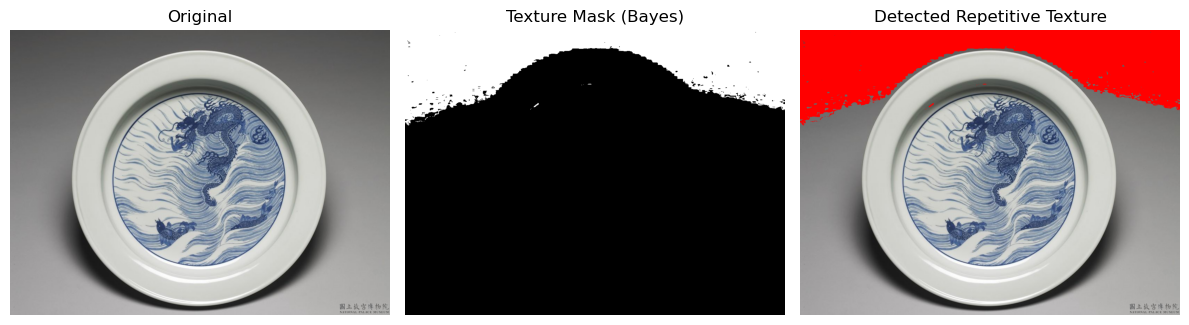

In [16]:
# 将整幅图的特征展平，做预测
X_all = features.reshape(-1, D)
y_pred = clf.predict(X_all)
y_map = y_pred.reshape(H, W)   # 0 / 1 的二维分类图

# 1 表示“重复纹理”，0 表示其他
texture_mask = (y_map == 1).astype(np.uint8)

# 可视化一下分割结果
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(texture_mask, cmap='gray')
plt.title("Texture Mask (Bayes)")
plt.axis("off")

plt.subplot(1,3,3)
# 把纹理区域用红色叠加显示
overlay = img.copy().astype(float)
overlay[texture_mask == 1] = [255, 0, 0]
overlay = overlay.astype(np.uint8)
plt.imshow(overlay)
plt.title("Detected Repetitive Texture")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
#接下来做修复图像
#可以根据效果微调的参数
#thresh = 20
#涂抹的颜色和原图差异很大，可以适当 增大（例如 30–40）
#如果涂抹颜色比较接近原图，可以适当 减小（例如 10–15）

#inpaint_radius = 3
#小一点 → 更贴近原图细节
#大一点（5~7）→ 修复更平滑，但容易“糊掉”

#kernel / iterations（膨胀）
#iterations=0，就不扩张，mask 边缘比较紧凑
#iterations=1~2，可以覆盖多一点边缘，防止残影

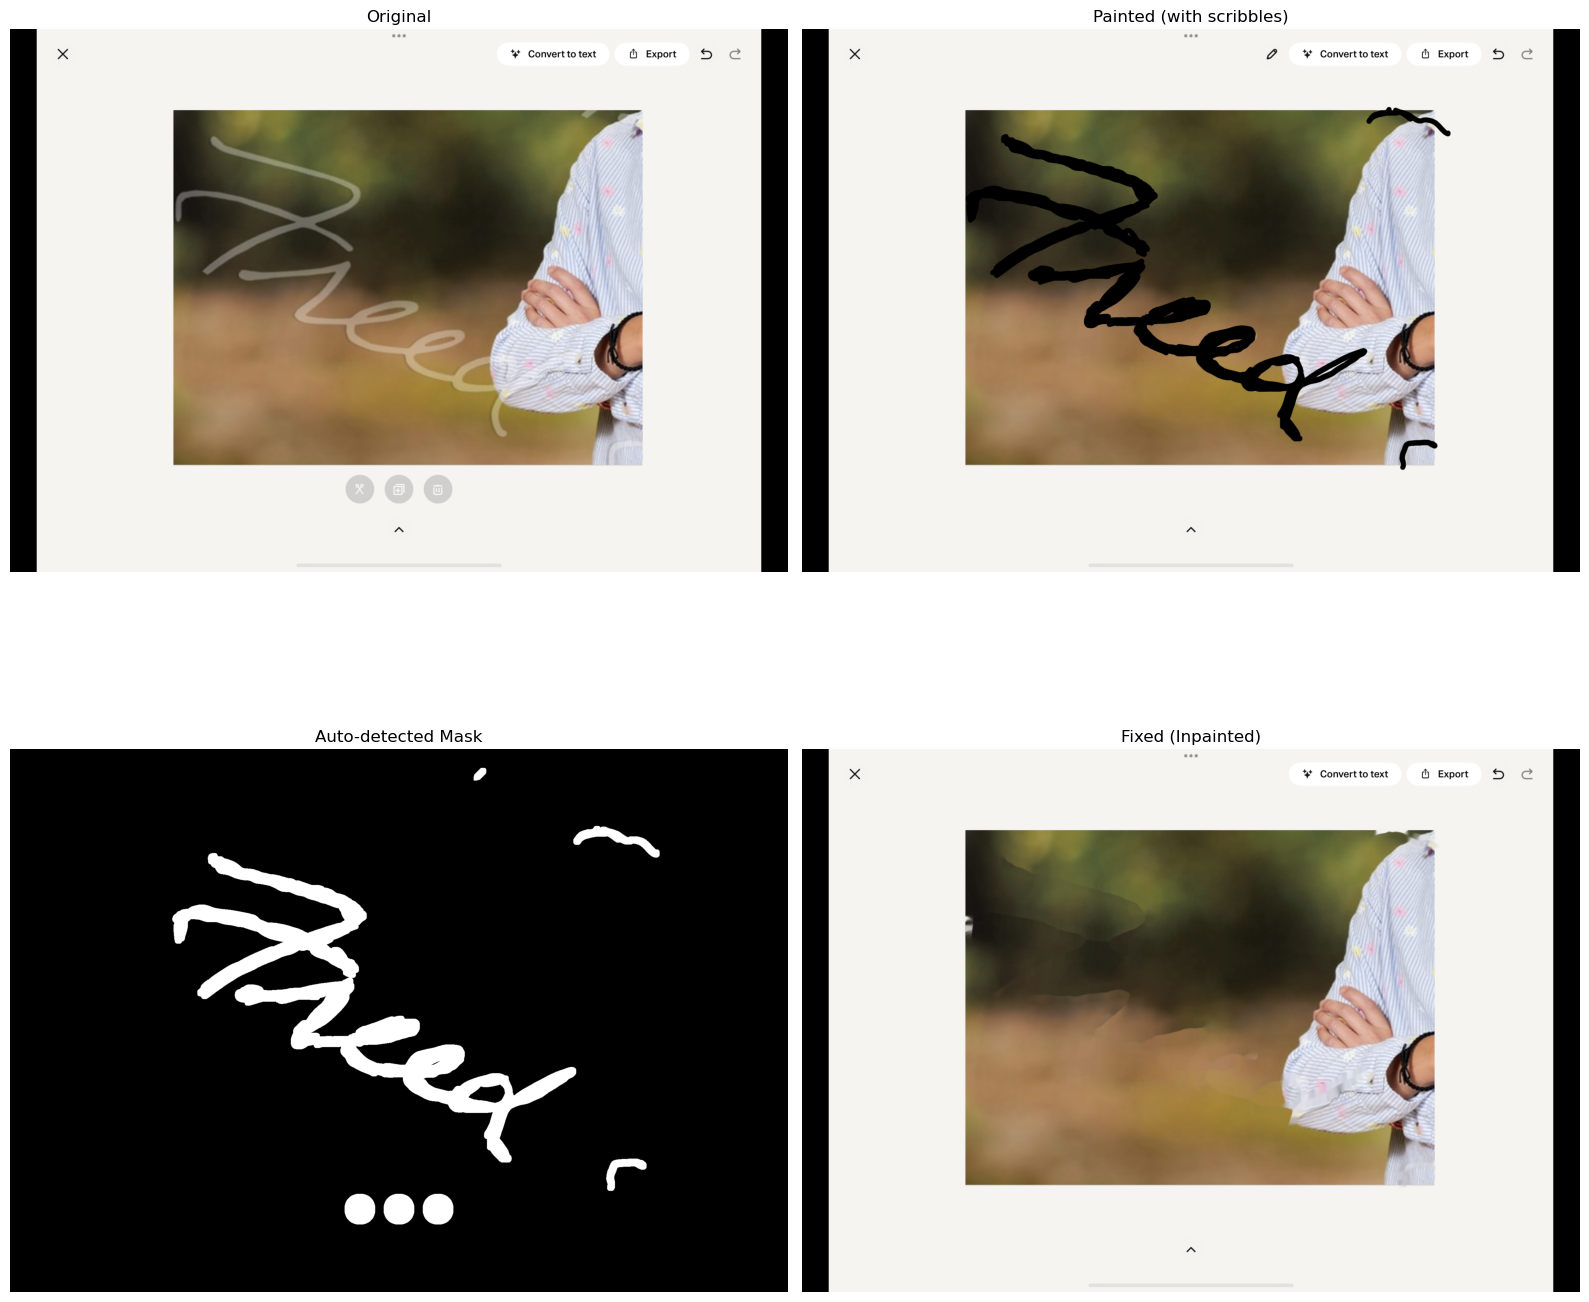

修复结果已保存到: fixed.png


In [31]:
import cv2
# ===== 1. 读入原图和 mask 图 =====
img_path = "ori.PNG"   # 替换为你的原图路径
mask_path = "o.PNG"      # 替换为你的 mask 路径


orig_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
painted_bgr = cv2.imread(mask_path, cv2.IMREAD_COLOR)

if orig_bgr is None:
    raise FileNotFoundError(f"无法读取原图: {orig_path}")
if painted_bgr is None:
    raise FileNotFoundError(f"无法读取涂抹图: {painted_path}")

if orig_bgr.shape != painted_bgr.shape:
    raise ValueError("原图和涂抹图的尺寸必须完全一致！")

# 为了展示方便，转成 RGB
orig_rgb    = cv2.cvtColor(orig_bgr,    cv2.COLOR_BGR2RGB)
painted_rgb = cv2.cvtColor(painted_bgr, cv2.COLOR_BGR2RGB)

# ========= 2. 计算差异图，提取你涂抹的区域作为 mask =========
# 绝对差分（逐像素 |orig - painted|）
diff_bgr = cv2.absdiff(orig_bgr, painted_bgr)

# 转为灰度，方便阈值
diff_gray = cv2.cvtColor(diff_bgr, cv2.COLOR_BGR2GRAY)

# 阈值，差异大于阈值的像素认为是你涂抹过的区域
# threshold 可以按需要调，比如 10~40 之间
thresh = 10
_, mask_raw = cv2.threshold(diff_gray, thresh, 255, cv2.THRESH_BINARY)

# 可选：用膨胀操作，让 mask 稍微扩张一点，避免边缘修复不完整
kernel = np.ones((3, 3), np.uint8)
mask_inpaint = cv2.dilate(mask_raw, kernel, iterations=3)

# ========= 3. 用 mask 对原图做“内容修复” =========
inpaint_radius = 10  # 邻域半径，视情况调节
inpainted_bgr = cv2.inpaint(
    orig_bgr,
    mask_inpaint,
    inpaint_radius,
    cv2.INPAINT_NS#cv2.INPAINT_TELEA  # 或 cv2.INPAINT_NS
)

inpainted_rgb = cv2.cvtColor(inpainted_bgr, cv2.COLOR_BGR2RGB)

# ========= 4. 显示对比效果 =========
plt.figure(figsize=(16, 16))

plt.subplot(2, 2, 1)
plt.imshow(orig_rgb)
plt.title("Original")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(painted_rgb)
plt.title("Painted (with scribbles)")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(mask_inpaint, cmap="gray")
plt.title("Auto-detected Mask")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(inpainted_rgb)
plt.title("Fixed (Inpainted)")
plt.axis("off")

plt.tight_layout()
plt.show()

# ========= 5. 保存修复结果 =========
out_path = "fixed.png"
cv2.imwrite(out_path, inpainted_bgr)
print(f"修复结果已保存到: {out_path}")
